In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In this section, we are going to trade HSI 1min

Import data for HSI 1Min and performs regular data cleaning procedures

In [13]:
data = pd.read_csv("HSI_1Min.csv")
data.head()

,Unnamed: 0,code,time_key,open,close,high,low,pe_ratio,turnover_rate,volume,turnover,change_rate,last_close
0,0,HK.HSImain,2020-08-03 09:16:00,24575.0,24528.0,24609.0,24505.0,0.0,0.0,1592,39096415.0,0.615309,24378.0
1,1,HK.HSImain,2020-08-03 09:17:00,24528.0,24495.0,24529.0,24495.0,0.0,0.0,543,13308279.0,-0.134540,24528.0
2,2,HK.HSImain,2020-08-03 09:18:00,24495.0,24485.0,24510.0,24480.0,0.0,0.0,556,13616890.0,-0.040825,24495.0
3,3,HK.HSImain,2020-08-03 09:19:00,24484.0,24492.0,24502.0,24481.0,0.0,0.0,312,7641323.0,0.028589,24485.0
4,4,HK.HSImain,2020-08-03 09:20:00,24493.0,24516.0,24539.0,24490.0,0.0,0.0,723,17725054.0,0.097991,24492.0


In [14]:
df = data[['time_key','open','high','low','close']]
df['time_key'] = pd.to_datetime(df['time_key'])
df.set_index('time_key',inplace=True)

In [15]:
df['return'] = df['close'] / df['close'].shift(1) - 1

# Thesis of the strategy

- We often heard TA trader (Technical Analysis Trader always wrong)
- TA trade lose money
- Hypothesis: Doing the exact opposite of them may be profitable 

So, most of the strategies TA trader use are classified as momentum strategies
They join the moves when asset price moves

Example:
- MA Cross Over
- MACD Cross Over
- Directional Movement Index
- Chart Pattern Breakout
- Price Action 
- etc...

They all enter at a very similar time because the signal are more or less the correlated to each other.

Strategy Idea: Let's use MA crossover as a proxy to other TA signals. When MA crossover, we do the opposite.

<AxesSubplot:xlabel='time_key'>

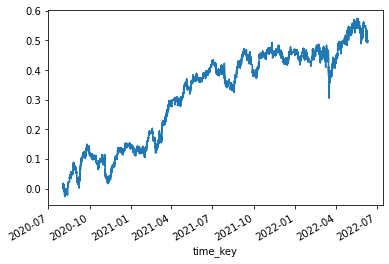

In [52]:
fast_period = 2
slow_period = 15
df['fast_ma'] = df['close'].rolling(fast_period).mean()
df['slow_ma'] = df['close'].rolling(slow_period).mean()

Short_Signal = df['fast_ma'] > df['slow_ma'] # We short instead
Long_Signal = df['fast_ma'] < df['slow_ma'] # We long instead

df['position'] = np.where(Long_Signal,1,np.where(Short_Signal,-1,0)) #Consistent size
df['pnl'] = df['position'] * df['return'].shift(-1)
df['cumpnl'] = df['pnl'].cumsum()

df['cumpnl'].plot()

It works, let's see the performance

In [53]:
print(f"Annualized Sharpe Ratio: {df['pnl'].mean() / df['pnl'].std() * np.sqrt(60*24*252)}")
print(f"Maximum Drawdown: {max(df['cumpnl'].cummax() - df['cumpnl'])*100} %")

Annualized Sharpe Ratio: 1.5298456936692006
Maximum Drawdown: 18.805834881850338 %


Let's make sure we didn't do it by luck

In [58]:
def backtest(params, plot=False):
    df['fast_ma'] = df['close'].rolling(params['fast_period']).mean()
    df['slow_ma'] = df['close'].rolling(params['slow_period']).mean()

    Short_Signal = df['fast_ma'] > df['slow_ma'] # We short instead
    Long_Signal = df['fast_ma'] < df['slow_ma'] # We long instead

    df['position'] = np.where(Long_Signal,1,np.where(Short_Signal,-1,0)) #Consistent size
    df['pnl'] = df['position'] * df['return'].shift(-1) # shift(-1) to calculate next period return
    df['cumpnl'] = df['pnl'].cumsum()

    sharpe = df['pnl'].mean() / df['pnl'].std() * np.sqrt(60*24*252)
    if plot:
        df['cumpnl'].plot()
    return sharpe

In [55]:
# Let's Assume a range of params and check their sharpe ratio and see if any big difference 
# Since the parameter space are small, we do a simple grid search
result = []
for f in range(2,8):
    for s in range(15,30):
        params = {
            'fast_period':f,
            'slow_period':s
        }
        result.append((params, backtest(params)))

In [56]:
result[:5]

[({'fast_period': 2, 'slow_period': 15}, 1.5298456936692006),
 ({'fast_period': 2, 'slow_period': 16}, 2.2201463064710376),
 ({'fast_period': 2, 'slow_period': 17}, 2.414955411830043),
 ({'fast_period': 2, 'slow_period': 18}, 2.342457806157941),
 ({'fast_period': 2, 'slow_period': 19}, 2.182751870142554)]

Let's visualize it and see the result

Text(0.5, 1.0, 'Sharpe Ratio')

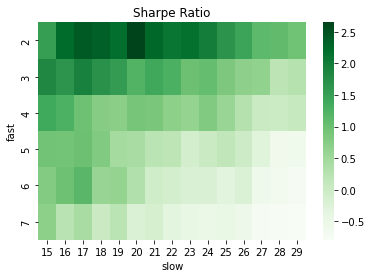

In [57]:
import seaborn as sns
grid = pd.DataFrame([[r[0]['fast_period'], r[0]['slow_period'], r[1]] for r in result],columns=['fast','slow','sharpe']).pivot_table('sharpe','fast','slow')
sns.heatmap(grid, cmap="Greens")
plt.title("Sharpe Ratio")


A range of parameter at the top region suggest there is likely a chance for this strategy to be profitable

2.6478924365799643

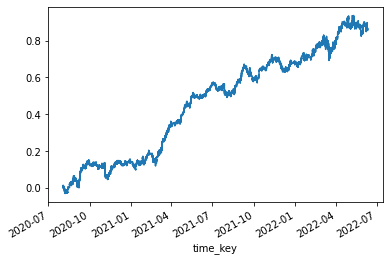

In [59]:
# Finalize our strategy
params = {
            'fast_period':2,
            'slow_period':20
        }
backtest(params, plot=True)


# Conclusion

- HSI market indeed lots of TA traders loss money using simple momentum strategy
Future ways to improve the strategy:
1. What are the best Market Session to execute
2. Alternative Data, Filters
3. TBC
